## Examining the dataset

In [116]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

final_df = pd.read_csv('../data/final_plot_release_emotion.csv')

Min and Max Year and Revenue

In [117]:
print(f"Minimum year is {final_df.Year.min()}")
print(f"Maximum year is {final_df.Year.max()}")
print(f"Minimum revenue is {final_df['Worldwide(USD)_Inflated'].min()}")
print(f"Maximum revenue is {final_df['Worldwide(USD)_Inflated'].max()}")

Minimum year is 2000
Maximum year is 2019
Minimum revenue is 35900.1999750028
Maximum revenue is 3784540437.008462


# Basic Analysis on our Megaset

### Foreign & Domestic Percentages Distribution

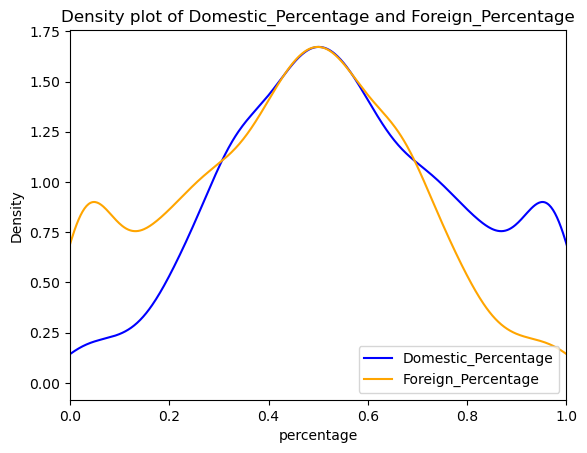

In [118]:
df_copy = final_df.copy(deep=True)
df_percentage = final_df.dropna(subset=['Domestic_Percentage', 'Foreign_Percentage'])

df_percentage.Domestic_Percentage.plot.density(color='blue')
df_percentage.Foreign_Percentage.plot.density(color='orange')

plt.title('Density plot of Domestic_Percentage and Foreign_Percentage')
plt.xlabel('percentage')
plt.xlim(0, 1)
plt.legend(["Domestic_Percentage", "Foreign_Percentage"], loc="lower right")
plt.show()



Most movies share their money-making between home and abroad, with many movies around the 50% split. However, some movies rely more on foreign audiences to make money.

## Features affecting the foreign percentage, and foreign gross

## Cluster the genres..

In [119]:
df_exploded = final_df.copy(deep=True)
df_exploded['Genres'] = final_df['Genres'].str.split(',')

df_exploded = df_exploded.explode('Genres')
df_exploded['Genres'] = df_exploded['Genres'].str.strip()
genre_counts = df_exploded['Genres'].value_counts()
genre_counts_20 = genre_counts.head(20)


In [120]:
genre_counts.head(30)

Genres
drama                     1325
comedy                    1021
thriller                   782
action                     712
adventure                  531
romance film               374
horror                     326
fantasy                    314
mystery                    286
crime fiction              272
action/adventure           270
romantic comedy            213
indie                      178
biography                  172
science fiction            168
family film                166
crime                      155
sci-fi                     147
romance                    146
period piece               142
comedy-drama               134
crime thriller             130
animation                  123
romantic drama             119
teen                       115
film adaptation            113
family                     106
musical                     90
history                     89
psychological thriller      88
Name: count, dtype: int64

In [121]:
## filter the movies not present in the first 20 categories..
genres = final_df['Genres'].str.split(',')
filtered_df = final_df[genres.apply(lambda x: any(item in x for item in genre_counts_20.index))]
print(f"original: {len(final_df)}")
print(f"filtered: {len(filtered_df)}") 


original: 2705
filtered: 2233


will lose 500 movies by filtering out the movies that are not in the top genres as a result try to create a cluster with the genres.. 

#### Clusters using sentence transformers and word string matching

In [137]:
keys = ['drama', 'comedy', 'thriller', 'action', 'adventure', 'romance film', 
        'horror', 'fantasy', 'mystery', 'crime', 'indie', 'biography', 
        'family', 'sci-fi', 'period piece', 'animation', 'teen', 
        'film adaptation', 'musical', 'history', 'coming of age', 
        'sports', 'war']

In [138]:

#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict


model = SentenceTransformer("all-MiniLM-L6-v2") 

genre_embeddings = {}
for genre in genre_counts.index:
    genre_embeddings[genre] = model.encode(genre, convert_to_tensor=True)

def assign_genres_to_clusters_with_overlap(keys, genre_counts, genre_embeddings, threshold=0.7):
    clusters = defaultdict(list)
    string_matched_genres = set() 

    # cluster based on string matching
    for genre in genre_counts.keys():
        for main_genre in keys:
            if main_genre in genre:
                clusters[main_genre].append(genre)
                string_matched_genres.add(genre)

    # cluster based on cosine similarity
    for genre in genre_counts.keys():
        for main_genre in keys:
            sim = util.cos_sim(genre_embeddings[genre], genre_embeddings[main_genre]).item()
            if sim >= threshold:
                clusters[main_genre].append(genre)

    # Drop duplicates
    final_clusters = defaultdict(list)
    for main_genre, group in clusters.items():
 
        unique_genres = []
        for genre in group:
            if genre not in unique_genres:
                unique_genres.append(genre)
        final_clusters[main_genre] = unique_genres


    ## add romantic fantasy and romantic drama to romance film, not able with the algorithm
    if "romance film" in final_clusters:
        if "romantic fantasy" not in final_clusters["romance film"]:
            final_clusters["romance film"].append("romantic fantasy")
        if "romantic drama" not in final_clusters["romance film"]:
            final_clusters["romance film"].append("romantic drama")
    
    # filter the genre  'film' since it's not a genre
    for main_genre in final_clusters:
        final_clusters[main_genre] = [genre for genre in final_clusters[main_genre] if genre != 'film']

    return final_clusters

clusters = assign_genres_to_clusters_with_overlap(keys, genre_counts, genre_embeddings, threshold=0.7)

for representative, group in clusters.items():
    total_count = sum(genre_counts.get(g, 0) for g in group)
    print(f"Representative Genre: {representative}")
    print(f"Total Count: {total_count}")
    print(f"Grouped Genres: {group}\n")

    

Representative Genre: drama
Total Count: 1805
Grouped Genres: ['drama', 'comedy-drama', 'romantic drama', 'family drama', 'costume drama', 'political drama', 'docudrama', 'musical drama', 'crime drama', 'courtroom drama', 'melodrama', 'marriage drama', 'childhood drama', 'historical drama', 'inspirational drama', 'addiction drama', 'erotic drama', 'legal drama', 'fantasy drama']

Representative Genre: comedy
Total Count: 1699
Grouped Genres: ['comedy', 'romantic comedy', 'comedy-drama', 'black comedy', 'fantasy comedy', 'comedy of manners', 'crime comedy', 'sex comedy', 'domestic comedy', 'action comedy', 'comedy film', 'comedy of errors', 'adventure comedy', 'screwball comedy', 'horror comedy', 'workplace comedy', 'musical comedy', 'heavenly comedy', 'tragicomedy', 'comedy western', 'courtroom comedy', 'comedy thriller', 'comedy horror']

Representative Genre: thriller
Total Count: 1086
Grouped Genres: ['thriller', 'crime thriller', 'psychological thriller', 'action thrillers', 'thril

Visualize genres by frequency

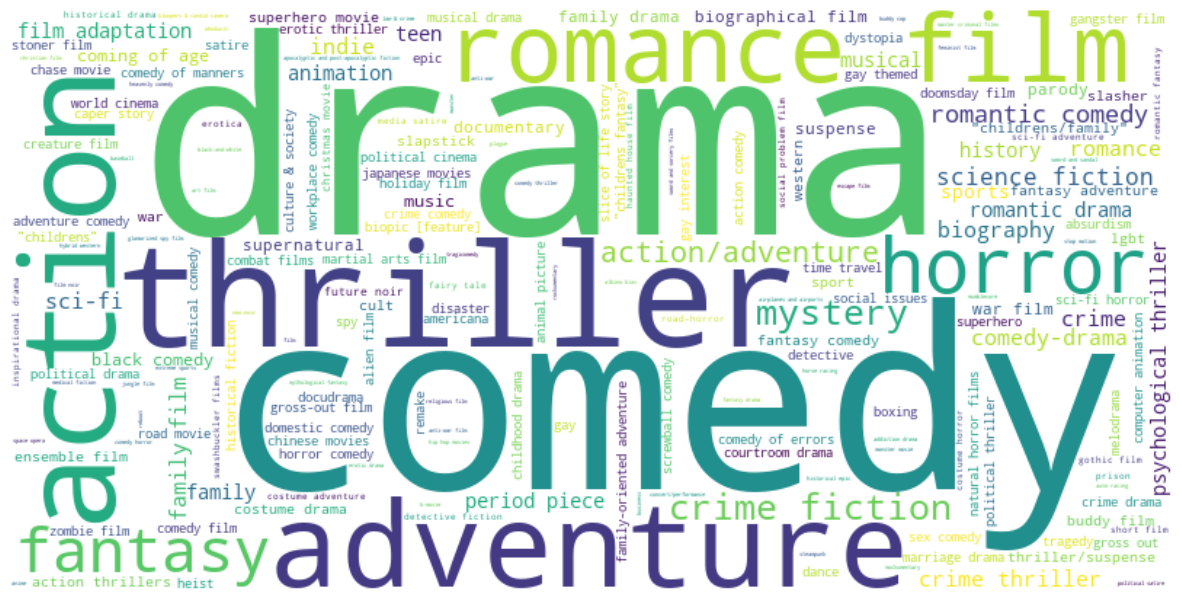

In [124]:
# !pip install wordcloud
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity

words = {}

for genre in genre_counts.keys():

    similarities = []
    for main_genre in keys:
        sim = cosine_similarity([genre_embeddings[genre]], [genre_embeddings[main_genre]])[0][0]
        similarities.append(sim)
    
    avg_similarity = np.mean(similarities)
    words[genre] = genre_counts.get(genre, 0) * avg_similarity

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### final genre mapping::

In [139]:
genre_mapping = {}
for main_genre, group in clusters.items():
    # Add the main genre's sub-genres to the mapping
    if main_genre not in genre_mapping:
        genre_mapping[main_genre] = group

# Output the genre_mapping dictionary
print("Genre Mapping:")
for genre, sub_genres in genre_mapping.items():
    print(f"{genre}: {sub_genres}")
    

Genre Mapping:
drama: ['drama', 'comedy-drama', 'romantic drama', 'family drama', 'costume drama', 'political drama', 'docudrama', 'musical drama', 'crime drama', 'courtroom drama', 'melodrama', 'marriage drama', 'childhood drama', 'historical drama', 'inspirational drama', 'addiction drama', 'erotic drama', 'legal drama', 'fantasy drama']
comedy: ['comedy', 'romantic comedy', 'comedy-drama', 'black comedy', 'fantasy comedy', 'comedy of manners', 'crime comedy', 'sex comedy', 'domestic comedy', 'action comedy', 'comedy film', 'comedy of errors', 'adventure comedy', 'screwball comedy', 'horror comedy', 'workplace comedy', 'musical comedy', 'heavenly comedy', 'tragicomedy', 'comedy western', 'courtroom comedy', 'comedy thriller', 'comedy horror']
thriller: ['thriller', 'crime thriller', 'psychological thriller', 'action thrillers', 'thriller/suspense', 'political thriller', 'erotic thriller', 'sci-fi thriller', 'comedy thriller']
action: ['action', 'action/adventure', 'action thrillers',

analysis of the the genres that most occur in pairs... 



## Genre anaylsis : add the genre mapping to the dataset..

Add the Genres onehot encoding..

In [140]:
profit_df = final_df.copy(deep=True)
profit_df['Genres'] = profit_df['Genres'].str.replace('/', ', ')

# create columns each genre in the mapping
for representative_genre, subgenres in genre_mapping.items():
    profit_df[representative_genre] = profit_df['Genres'].apply(
        lambda x: 1 if any(subgenre in x for subgenre in subgenres) else 0
    )

# Drop rows where no genre is present in the mapping
genre_columns = list(genre_mapping.keys())
profit_df = profit_df[profit_df[genre_columns].sum(axis=1) > 0]

print(f"Number of movies before genre filtering: {len(final_df)}")
print(f"Number of movies after genre filtering: {len(profit_df)}")

Number of movies before genre filtering: 2705
Number of movies after genre filtering: 2689


In [141]:
profit_df['Genres']

0                         drama, horror, sci-fi, thriller
1       thriller, adventure, costume drama, action, ad...
2       action thrillers, thriller, action, crime fiction
3                             action, drama, history, war
4                               biography, drama, history
                              ...                        
2700                     parody, comedy of errors, comedy
2701          action, adventure, comedy, mystery, romance
2702          science fiction, action, fantasy, adventure
2703    action, adventure, animation, comedy, crime, f...
2704    thriller, science fiction, action, adventure, ...
Name: Genres, Length: 2689, dtype: object

In [142]:
## now replace the Genres column with the
profit_df['Genres'] = profit_df.apply(lambda x: ', '.join([genre for genre in genre_columns if x[genre] == 1]), axis=1)

In [143]:
profit_df['Genres']

0                         drama, thriller, horror, sci-fi
1       drama, thriller, action, adventure, romance fi...
2                                 thriller, action, crime
3                             drama, action, history, war
4                               drama, biography, history
                              ...                        
2700                                               comedy
2701     comedy, action, adventure, romance film, mystery
2702                   action, adventure, fantasy, sci-fi
2703    comedy, action, adventure, mystery, crime, fam...
2704                  thriller, action, adventure, sci-fi
Name: Genres, Length: 2689, dtype: object

Add success rate columns..

In [144]:
profit_df['Worldwide_profit'] = final_df['Worldwide(USD)_Inflated']/final_df['Budget(USD)_Inflated']

In [146]:
profit_df.columns

Index(['Name', 'Countries', 'Genres', 'Budget(USD)_Inflated',
       'Domestic(USD)_Inflated', 'Domestic_Percentage',
       'Foreign(USD)_Inflated', 'Foreign_Percentage',
       'Worldwide(USD)_Inflated', 'Runtime(mins)', 'Rating', 'Audience_Score',
       'Critics_Score', 'plot_summary', 'Month', 'Day', 'Year',
       'Foreign_higher', 'emotion', 'emotion_score', 'drama', 'comedy',
       'thriller', 'action', 'adventure', 'romance film', 'horror', 'fantasy',
       'mystery', 'crime', 'indie', 'biography', 'family', 'sci-fi',
       'period piece', 'animation', 'teen', 'film adaptation', 'musical',
       'history', 'coming of age', 'sports', 'war', 'Worldwide_profit'],
      dtype='object')

In [147]:
profit_df.drop(columns = [ "Countries"], inplace = True)

In [148]:
profit_df.columns

Index(['Name', 'Genres', 'Budget(USD)_Inflated', 'Domestic(USD)_Inflated',
       'Domestic_Percentage', 'Foreign(USD)_Inflated', 'Foreign_Percentage',
       'Worldwide(USD)_Inflated', 'Runtime(mins)', 'Rating', 'Audience_Score',
       'Critics_Score', 'plot_summary', 'Month', 'Day', 'Year',
       'Foreign_higher', 'emotion', 'emotion_score', 'drama', 'comedy',
       'thriller', 'action', 'adventure', 'romance film', 'horror', 'fantasy',
       'mystery', 'crime', 'indie', 'biography', 'family', 'sci-fi',
       'period piece', 'animation', 'teen', 'film adaptation', 'musical',
       'history', 'coming of age', 'sports', 'war', 'Worldwide_profit'],
      dtype='object')

In [149]:
profit_df.to_csv('../data/final_v2.csv', index=False)

## Plots

<Axes: >

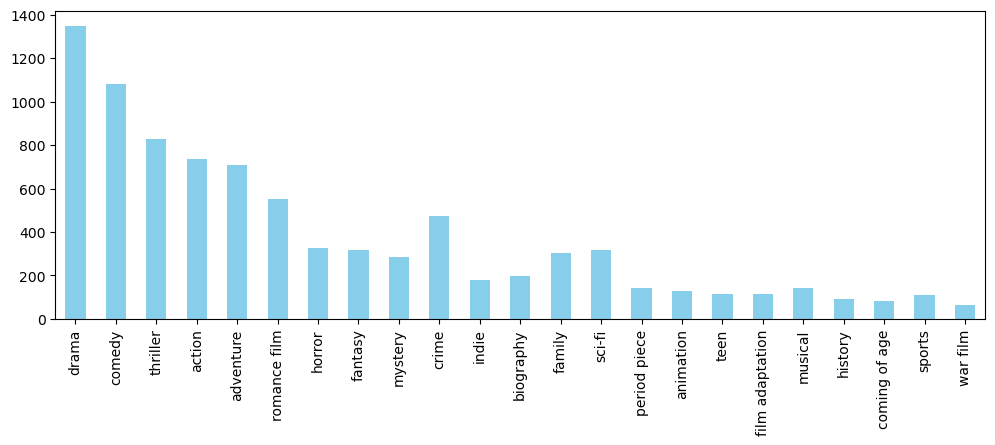

In [87]:
# frequency plot
genre_final_counts = profit_df[genre_columns].sum()
genre_final_counts.sort_values(ascending=False)
genre_final_counts.plot(kind='bar', color='skyblue', figsize=(12, 4))

In [93]:


columns = list(genre_mapping.keys()) + ["Genres"]

# Sorting the DataFrame by 'Worldwide(USD)_Inflated' and selecting the first row
top_row = profit_df.sort_values(by='Worldwide(USD)_Inflated', ascending=False)[columns].head(1)

# Print the result
top_row


,drama,comedy,thriller,action,adventure,romance film,horror,fantasy,mystery,crime,...,period piece,animation,teen,film adaptation,musical,history,coming of age,sports,war film,Genres
207,0,0,1,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,"thriller, science fiction, adventure, computer..."


Plotting a bar plot showcasing the sum of the domestic and foregin gross for each chosen genre

<Figure size 1200x600 with 0 Axes>

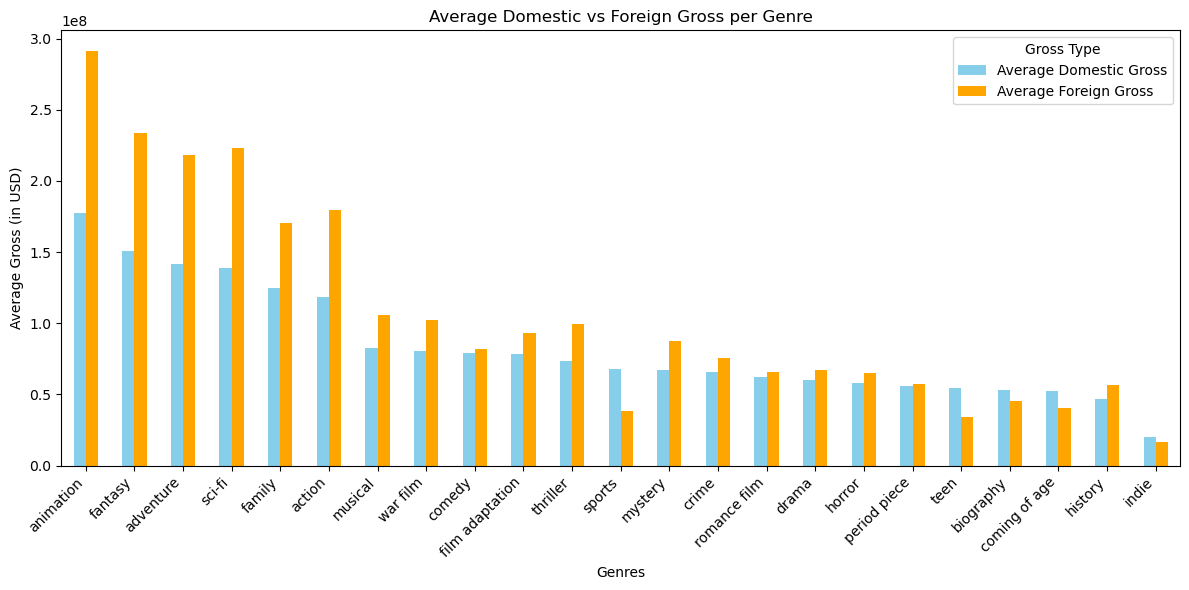

In [94]:
## NOT INDICATIVE BECAUSE OF THE HUGE PRESENCE OF OUTLIERS
genre_columns = list(genre_mapping.keys())

# Initialize lists to store results
average_domestic = []
average_foreign = []

# Loop through each genre to calculate averages
for genre in genre_columns:
    domestic_mean = profit_df[profit_df[genre] == 1]['Domestic(USD)_Inflated'].mean()
    foreign_mean = profit_df[profit_df[genre] == 1]['Foreign(USD)_Inflated'].mean()
    average_domestic.append(domestic_mean)
    average_foreign.append(foreign_mean)


average_gross_per_genre = pd.DataFrame({
    'Genre': genre_columns,
    'Average Domestic Gross': average_domestic,
    'Average Foreign Gross': average_foreign
})


average_gross_per_genre = average_gross_per_genre.sort_values(by='Average Domestic Gross', ascending=False)


plt.figure(figsize=(12, 6))
average_gross_per_genre.set_index('Genre').plot(kind='bar', stacked=False, color=['skyblue', 'orange'], figsize=(12, 6))
plt.title('Average Domestic vs Foreign Gross per Genre')
plt.ylabel('Average Gross (in USD)')
plt.xlabel('Genres')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gross Type')
plt.tight_layout()
plt.show()


This bar plot showcases the dominance of foreign gross (orange) over domestic gross (blue) across all of the top 20 genres, especially for action, adventure, drama, thriller and family film; indicating strong international appeal. In contrast, genres like comedy, romance film and crime fiction show a more balanced domestic and foreign gross, suggesting greater resonance with U.S. audiences. Overall, while this chart reveals genre-specific market preferences, it is susceptible to skewing, as genres with more movies will naturally have higher gross totals.

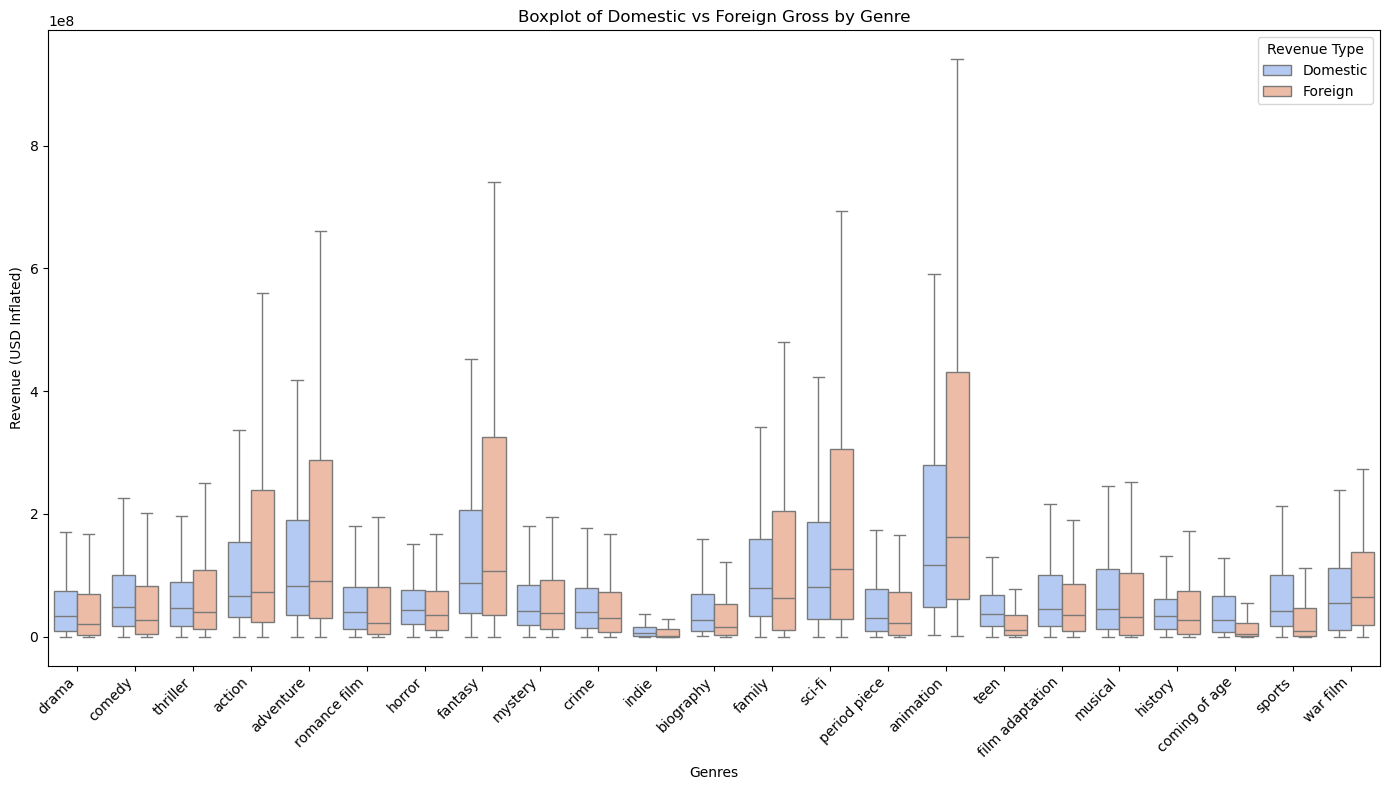

In [95]:
plot_data = []

for genre in genre_columns:

    genre_data = profit_df[profit_df[genre] == 1]
    for _, row in genre_data.iterrows():
        plot_data.append({'Genre': genre, 'Revenue': row['Domestic(USD)_Inflated'], 'Type': 'Domestic'})
        plot_data.append({'Genre': genre, 'Revenue': row['Foreign(USD)_Inflated'], 'Type': 'Foreign'})

plot_df = pd.DataFrame(plot_data)
plt.figure(figsize=(14, 8))
sns.boxplot(data=plot_df, x='Genre', y='Revenue', hue='Type', palette='coolwarm', showfliers=False)
plt.title('Boxplot of Domestic vs Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Revenue (USD Inflated)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Revenue Type')
plt.tight_layout()
plt.show()


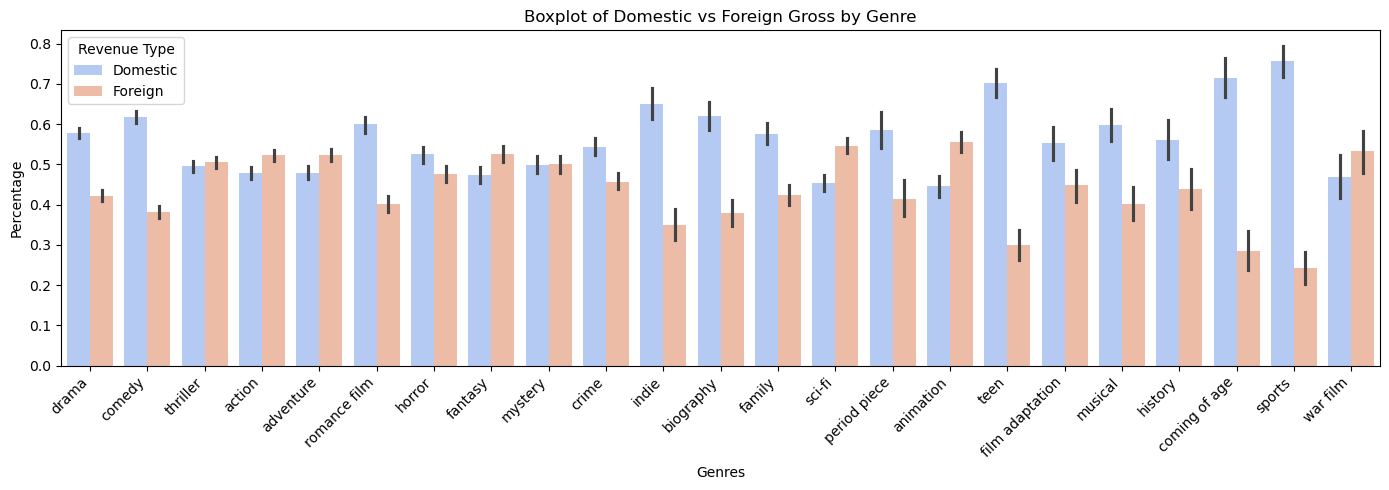

In [96]:
plot_data = []

for genre in genre_columns:

    genre_data = profit_df[profit_df[genre] == 1]
    for _, row in genre_data.iterrows():
        plot_data.append({'Genre': genre, 'Revenue': row['Domestic_Percentage'], 'Type': 'Domestic'})
        plot_data.append({'Genre': genre, 'Revenue': row['Foreign_Percentage'], 'Type': 'Foreign'})

plot_df = pd.DataFrame(plot_data)
plt.figure(figsize=(14, 5))
sns.barplot(data=plot_df, x='Genre', y='Revenue', hue='Type', palette='coolwarm')
plt.title('Boxplot of Domestic vs Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Revenue Type')
plt.tight_layout()
plt.show()


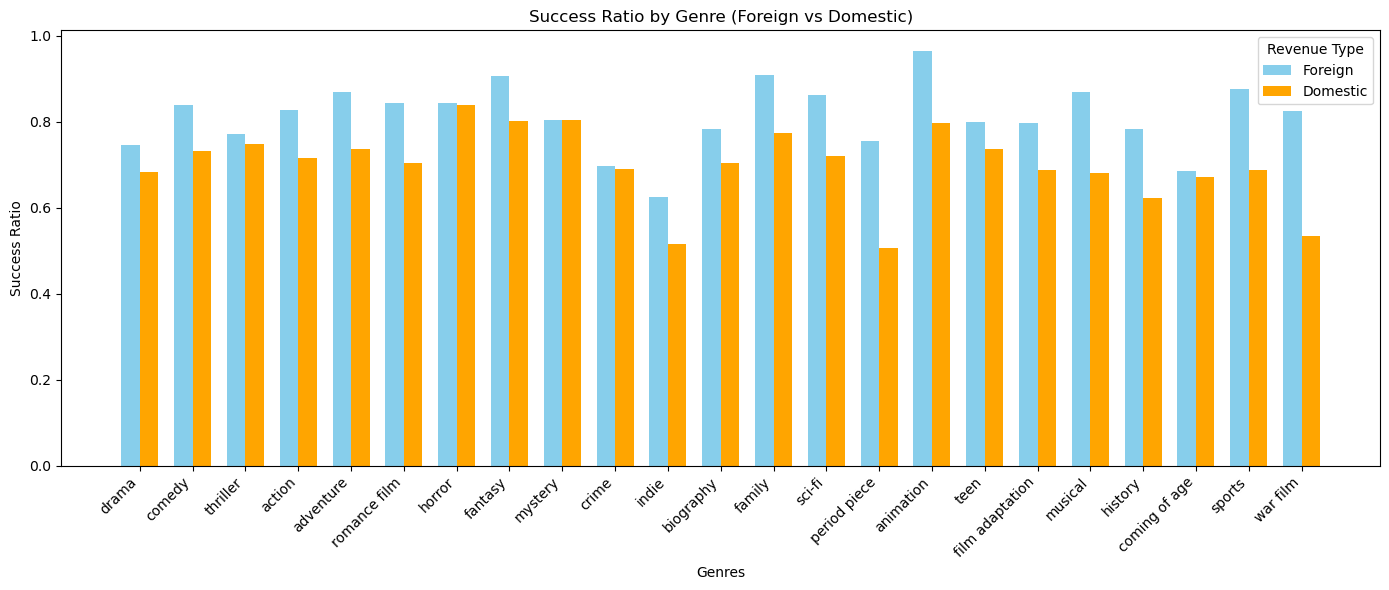

In [ ]:
plot_data = []
ratio = []
ratio_2 = []

for genre in genre_columns:
    genre_data = profit_df[profit_df[genre] == 1]

    successful_movies = genre_data[(genre_data['Worldwide_profit'] > 1) & (genre_data['Foreign_Percentage'] > 0.5)]
    ratio_value = len(successful_movies) / len(genre_data[genre_data['Foreign_Percentage'] > 0.5])

    successful_domestic_movies = genre_data[(genre_data['Worldwide_profit'] > 1) & (genre_data['Domestic_Percentage'] > 0.5)]
    ratio_value_2 = len(successful_domestic_movies) / len(genre_data[genre_data['Domestic_Percentage'] > 0.5])

    ratio.append({'Genre': genre, 'Ratio': ratio_value})
    ratio_2.append({'Genre': genre, 'Ratio': ratio_value_2})

plot_df = pd.DataFrame(ratio)
plot_df_2 = pd.DataFrame(ratio_2)

plt.figure(figsize=(14, 6))

bar_width = 0.35
index = np.arange(len(plot_df))

plt.bar(index, plot_df['Ratio'], bar_width, color='skyblue', label='Foreign')
plt.bar(index + bar_width, plot_df_2['Ratio'], bar_width, color='orange', label='Domestic')

plt.xlabel('Genres')
plt.ylabel('Success Ratio')
plt.title('Success Ratio by Genre (Foreign vs Domestic)')
plt.xticks(index + bar_width / 2, plot_df['Genre'], rotation=45, ha='right')
plt.legend(title='Revenue Type')
plt.tight_layout()

plt.show()



## Are movies that fair better outside movies that most likely succeed? indipendent on the budget.

If a movie is more successful, it's likely to have a higher foreign audience share, but this doesn't necessarily imply that the foreign audience share causes the success.

. Correlation Analysis:  
You can check the correlation between the Foreign_Percentage and Worldwide_profit while controlling for other variables that might influence success. This would help you identify if the relationship is indeed strong between foreign audience share and worldwide success.

In [847]:
correlation = profit_df[['Foreign_Percentage', 'Foreign(USD)_Inflated', 'Domestic(USD)_Inflated', 'Domestic_Percentage', 'Worldwide_profit',  'Worldwide(USD)_Inflated', 'Budget(USD)_Inflated', 'Runtime(mins)', 'Critics_Score']].corr()
correlation


,Foreign_Percentage,Foreign(USD)_Inflated,Domestic(USD)_Inflated,Domestic_Percentage,Worldwide_profit,Worldwide(USD)_Inflated,Budget(USD)_Inflated,Runtime(mins),Critics_Score
Foreign_Percentage,1.000000,0.376069,0.177629,-1.000000,0.012883,0.315086,0.336068,0.183167,0.048466
Foreign(USD)_Inflated,0.376069,1.000000,0.858847,-0.376069,0.050486,0.981667,0.749454,0.361761,0.176167
Domestic(USD)_Inflated,0.177629,0.858847,1.000000,-0.177629,0.076120,0.940736,0.703353,0.337507,0.216004
Domestic_Percentage,-1.000000,-0.376069,-0.177629,1.000000,-0.012883,-0.315086,-0.336068,-0.183167,-0.048466
Worldwide_profit,0.012883,0.050486,0.076120,-0.012883,1.000000,0.061751,-0.074726,-0.053178,0.078259
Worldwide(USD)_Inflated,0.315086,0.981667,0.940736,-0.315086,0.061751,1.000000,0.757924,0.365105,0.197014
Budget(USD)_Inflated,0.336068,0.749454,0.703353,-0.336068,-0.074726,0.757924,1.000000,0.414221,0.016339
Runtime(mins),0.183167,0.361761,0.337507,-0.183167,-0.053178,0.365105,0.414221,1.000000,0.249027
Critics_Score,0.048466,0.176167,0.216004,-0.048466,0.078259,0.197014,0.016339,0.249027,1.000000


<Axes: >

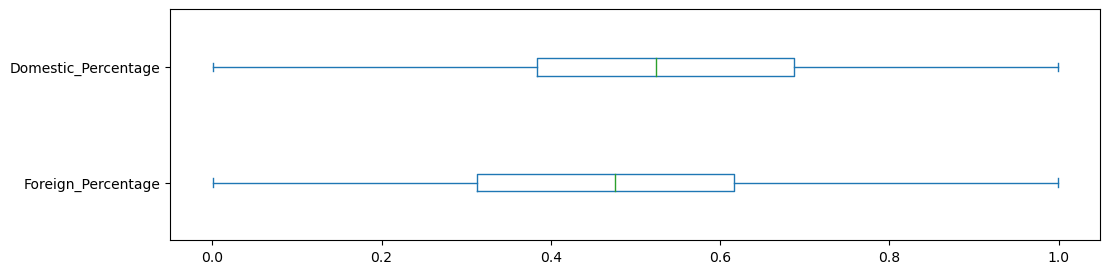

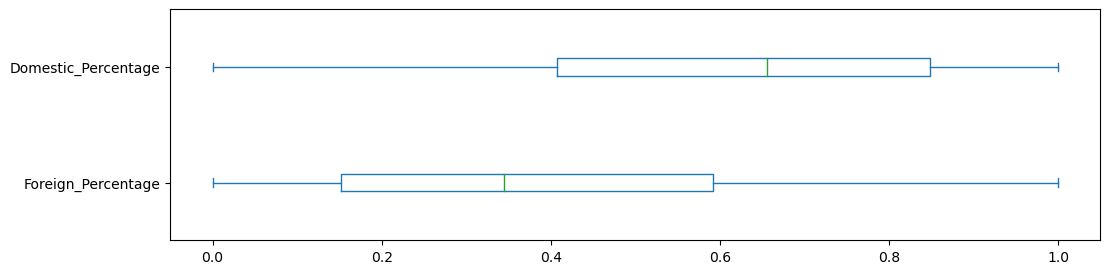

In [ ]:
# Apply the conditions using logical operators & and parentheses for proper precedence
profit_df[(profit_df['Worldwide_profit'] > 1) ][['Foreign_Percentage', 'Domestic_Percentage']].plot(kind='box', vert=False, figsize=(12, 3))
profit_df[(profit_df['Worldwide_profit'] < 1) ][['Foreign_Percentage', 'Domestic_Percentage']].plot(kind='box', vert=False, figsize=(12, 3))

#### correlations..

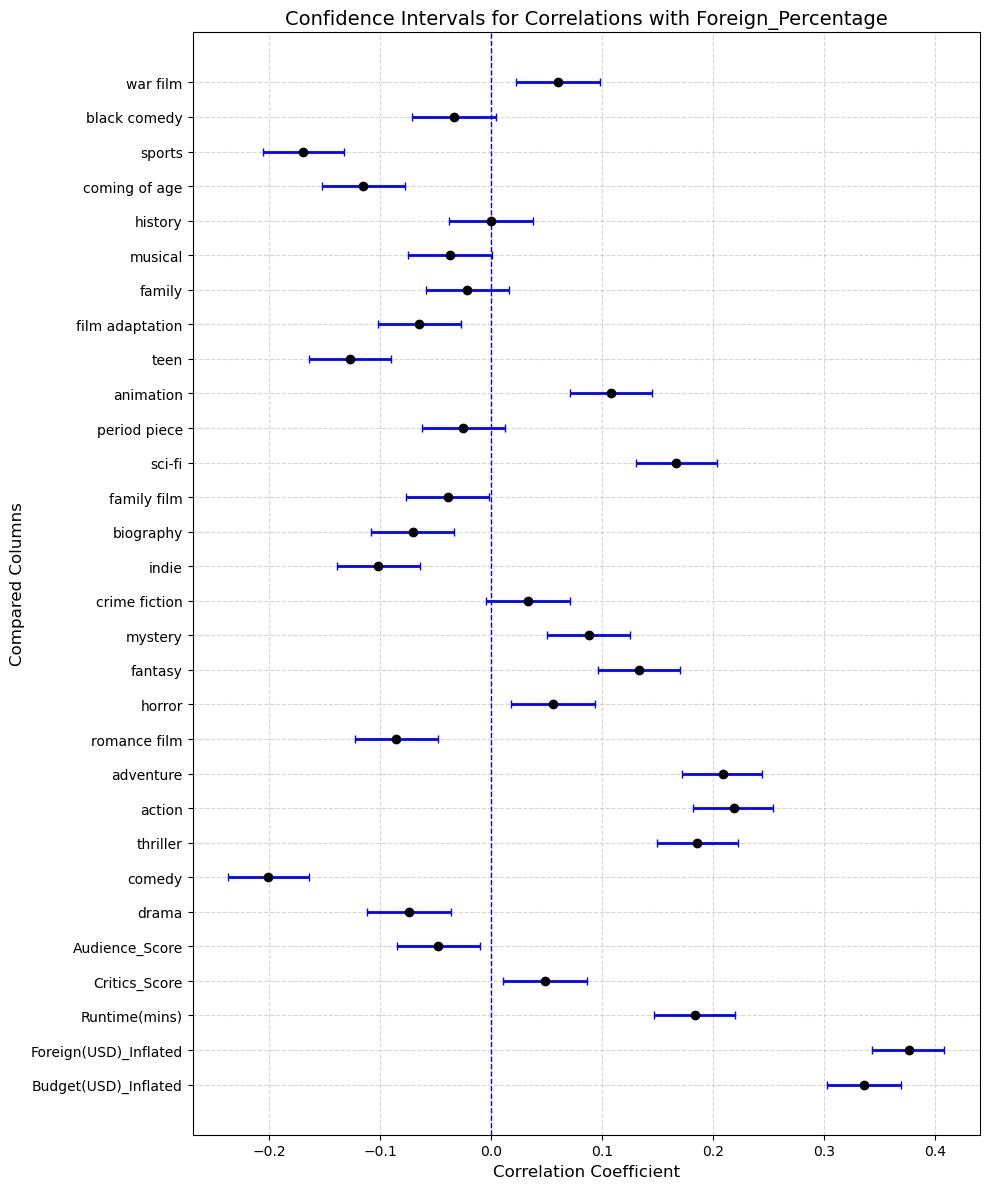

,Compared Column,Correlation,P-Value,Lower_CI,Upper_CI
0,Budget(USD)_Inflated,0.336,0.000,0.302,0.369
1,Foreign(USD)_Inflated,0.376,0.000,0.343,0.408
2,Runtime(mins),0.183,0.000,0.147,0.219
3,Critics_Score,0.048,0.012,0.011,0.086
4,Audience_Score,-0.048,0.013,-0.085,-0.010
5,drama,-0.074,0.000,-0.111,-0.037
6,comedy,-0.201,0.000,-0.237,-0.164
7,thriller,0.186,0.000,0.149,0.222
8,action,0.218,0.000,0.182,0.254
9,adventure,0.208,0.000,0.172,0.244


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns of interest and other columns for comparison
columns_of_interest_tot = ['Budget(USD)_Inflated', 'Foreign(USD)_Inflated', 'Foreign_Percentage', 
                           'Runtime(mins)', 'Critics_Score', 'Audience_Score'] + list(genre_mapping.keys())

# Target column and other columns to compare
target_column = 'Foreign_Percentage'
other_columns = [col for col in columns_of_interest_tot if col != target_column]

# Function to calculate correlation coefficients and p-values
def compute_correlations(df, target_col, other_columns):
    results = []
    for col in other_columns:
        valid_data = df[[target_col, col]].dropna()
        if len(valid_data) > 2:  # Ensure enough data points for Pearson's correlation
            corr, p_val = pearsonr(valid_data[target_col], valid_data[col])
            n = len(valid_data)  # Sample size
            results.append({
                'Compared Column': col,
                'Correlation': corr,
                'P-Value': p_val,
                'Sample Size': n
            })
    return pd.DataFrame(results)

# Function to calculate confidence intervals using Fisher transformation
def confidence_interval(corr, n, alpha=0.05):
    """Compute confidence interval for correlation."""
    if np.abs(corr) < 1:  # Fisher transformation is invalid for |corr| = 1
        z = 0.5 * np.log((1 + corr) / (1 - corr))  # Fisher transformation
        se = 1 / np.sqrt(n - 3)  # Standard error
        z_critical = 1.96  # For 95% confidence interval
        lower_z = z - z_critical * se
        upper_z = z + z_critical * se
        # Transform back to correlation scale
        lower_corr = (np.exp(2 * lower_z) - 1) / (np.exp(2 * lower_z) + 1)
        upper_corr = (np.exp(2 * upper_z) - 1) / (np.exp(2 * upper_z) + 1)
        return lower_corr, upper_corr
    else:
        return corr, corr  # If |corr| = 1, confidence interval is exact

# Calculate correlations, p-values, and confidence intervals
correlation_results = compute_correlations(profit_df, target_column, other_columns)

# Add confidence intervals
correlation_results['Lower_CI'], correlation_results['Upper_CI'] = zip(*correlation_results.apply(
    lambda row: confidence_interval(row['Correlation'], row['Sample Size']), axis=1))

# Plot correlations with confidence intervals
plt.figure(figsize=(10, 12))
plt.errorbar(
    correlation_results['Correlation'], 
    correlation_results['Compared Column'], 
    xerr=[correlation_results['Correlation'] - correlation_results['Lower_CI'], 
          correlation_results['Upper_CI'] - correlation_results['Correlation']],
    fmt='o', color='black', ecolor='blue', elinewidth=2, capsize=3
)
plt.axvline(0, color='blue', linestyle='--', linewidth=1)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Compared Columns", fontsize=12)
plt.title(f"Confidence Intervals for Correlations with {target_column}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display the table with results
display(correlation_results[['Compared Column', 'Correlation', 'P-Value', 'Lower_CI', 'Upper_CI']].round(3))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the columns of interest and other columns for comparison
columns_of_interest_tot = ['Budget(USD)_Inflated', 'Foreign(USD)_Inflated', 
                           'Runtime(mins)', 'Critics_Score', 'Audience_Score'] + list(genre_mapping.keys())

correlation_df = profit_df.copy(deep=True)
correlation_df = correlation_df[columns_of_interest_tot ]

# Prepare the dataset (with one-hot encoded genres)
X = correlation_df.drop(columns=['Foreign(USD)_Inflated'])
y = correlation_df['Foreign(USD)_Inflated']

# Train a Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Display the feature importances
for feature, importance in zip(X.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")


## if you want to analyse foreign_usd need to match based on the budget.. 


Feature: Budget(USD)_Inflated, Importance: 0.6712952005058541
Feature: Runtime(mins), Importance: 0.057692947715939975
Feature: Critics_Score, Importance: 0.06413662269209294
Feature: Audience_Score, Importance: 0.10225628695922333
Feature: drama, Importance: 0.009203415516297756
Feature: comedy, Importance: 0.004340681269139036
Feature: thriller, Importance: 0.005724986242953038
Feature: action, Importance: 0.009092662447229925
Feature: adventure, Importance: 0.003903177862591773
Feature: romance film, Importance: 0.004038952057631526
Feature: horror, Importance: 0.0027908161574159087
Feature: fantasy, Importance: 0.010642328507784213
Feature: mystery, Importance: 0.002819701283001402
Feature: crime fiction, Importance: 0.008316910863008628
Feature: indie, Importance: 0.00025704229183653147
Feature: biography, Importance: 0.0008848575989866397
Feature: family film, Importance: 0.003191064656991294
Feature: sci-fi, Importance: 0.00866104231040555
Feature: period piece, Importance: 0.00

In [785]:
correlation_results

,Target Column,Compared Column,Correlation,P-Value
0,Foreign(USD)_Inflated,Year,0.098106,3.055164e-07
1,Foreign(USD)_Inflated,Budget(USD)_Inflated,0.749454,0.000000e+00
2,Foreign(USD)_Inflated,Domestic(USD)_Inflated,0.858847,0.000000e+00
3,Foreign(USD)_Inflated,Domestic_Percentage,-0.376069,6.972666e-92
4,Foreign(USD)_Inflated,Worldwide(USD)_Inflated,0.981667,0.000000e+00
...,...,...,...,...
63,Foreign_Percentage,coming of age,-0.115047,1.860035e-09
64,Foreign_Percentage,sports,-0.169111,7.428765e-19
65,Foreign_Percentage,black comedy,-0.033276,8.311152e-02
66,Foreign_Percentage,war film,0.060351,1.661515e-03


# Proportion of Domestic vs Foreign gross for US movies over time

Domestic vs Foreign Income, Total and Percentage, for American movies over time

In [801]:
year_min = final_df['Year'].min()
year_max = final_df['Year'].max()

print(f"The range of the 'Year' column is: {year_min} to {year_max}")

The range of the 'Year' column is: 2000 to 2019


In [802]:
# ANALYSING ONLY UNITED STATES
df_gross = final_df.drop(columns=['Budget(USD)_Inflated', 'Genres'])
df_gross = df_gross[df_gross['Countries'].str.contains('united states', na=False)]
df_gross = df_gross.dropna()
df_gross



,Name,Year,Countries,Domestic(USD)_Inflated,Domestic_Percentage,Foreign(USD)_Inflated,Foreign_Percentage,Worldwide(USD)_Inflated,Runtime(mins),Rating,Audience_Score,Critics_Score
0,10 cloverfield lane,2016,united states,8.760602e+07,0.654010,4.634613e+07,0.345990,1.339521e+08,103,pg-13,0.79,0.91
1,"10,000 bc",2008,united states of america,1.301309e+08,0.351333,2.402606e+08,0.648667,3.703914e+08,109,pg-13,0.37,0.10
2,12 rounds,2009,united states of america,1.667757e+07,0.708013,6.877890e+06,0.291987,2.355546e+07,108,pg-13,0.45,0.31
3,12 strong,2018,united states,5.209113e+07,0.644274,2.876133e+07,0.355726,8.085246e+07,130,r,0.62,0.50
4,12 years a slave,2013,united states of america,7.195247e+07,0.301875,1.663993e+08,0.698125,2.383517e+08,134,r,0.90,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...
2723,zoolander,2001,united states of america,7.826600e+07,0.743197,2.704388e+07,0.256803,1.053099e+08,90,pg-13,0.80,0.64
2724,zoolander 2,2016,united states,3.506124e+07,0.508592,3.387664e+07,0.491408,6.893788e+07,101,pg-13,0.20,0.22
2725,zoom,2006,united states of america,1.717625e+07,0.958658,7.407176e+05,0.041342,1.791697e+07,93,pg,0.34,0.05
2726,zootopia,2016,united states,4.147601e+08,0.333340,8.294952e+08,0.666660,1.244255e+09,108,pg,0.92,0.98


The code below designs a histogram which gives the distribution of movies produced per year. 

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

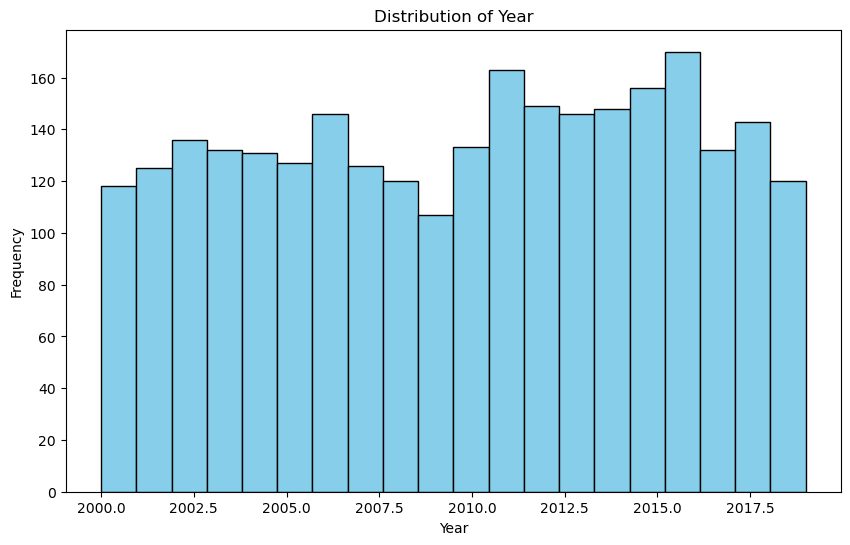

In [803]:
plt.figure(figsize=(10, 6))
plt.hist(df_gross['Year'].dropna(), bins=20, edgecolor='black', color='skyblue')
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid

The histogram demonstrates a clear bias in the dataset towards movies that were produced more recently, this could in large part be down to the increased collection of data once the information age arrived.

In [804]:
year_min = df_gross['Year'].min()
year_max = df_gross['Year'].max()

print(f"The range of the 'Year' column is: {year_min} to {year_max}")


The range of the 'Year' column is: 2000 to 2019


In order to see how the worldwide gross for US films has changed over time, we use a scatterplot for each of the American movies in our dataset.

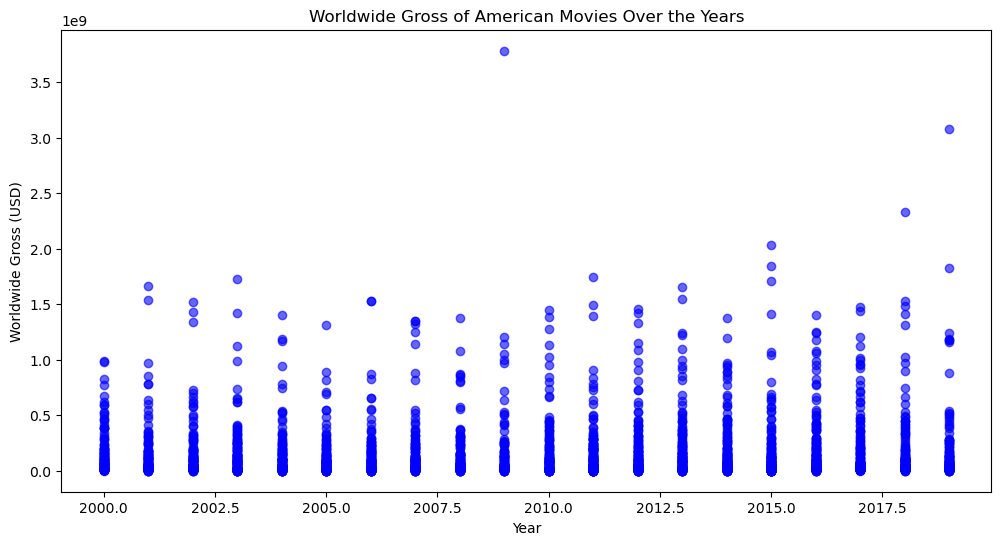

In [805]:
plt.figure(figsize=(12, 6))
plt.scatter(df_gross['Year'], df_gross['Worldwide(USD)_Inflated'], color='blue', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Worldwide Gross (USD)')
plt.title('Worldwide Gross of American Movies Over the Years')

plt.show()

The scatterplot does not show any clear trend towards an overall increase in worldwide gross as we approach the present day despite factors like inflation which would have suggested an increase.

The bar chart featured below was created with the intent of checking the trends in average worldwide gross per year (from 2000 to 2016) with a domestic/foreign gross split.

In [806]:
df_gross = df_gross[(df_gross['Year'] > 2000)&(df_gross['Year'] < 2019)]

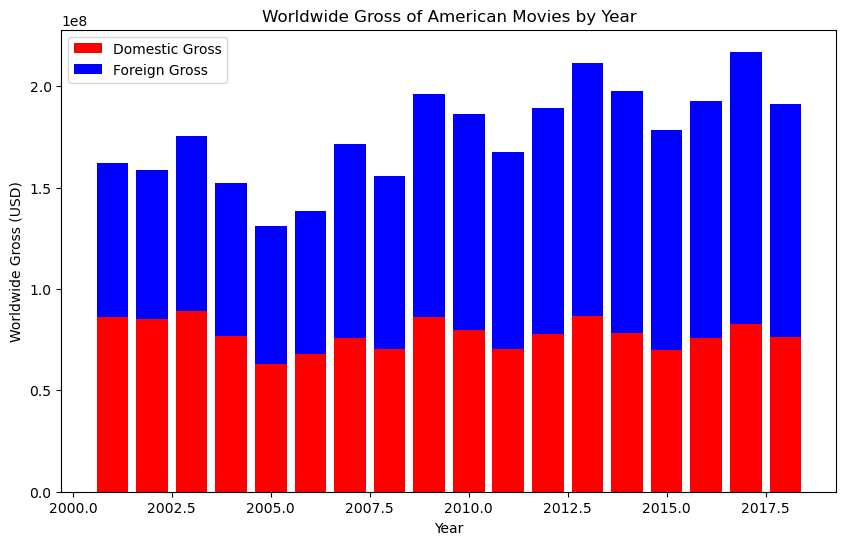

In [807]:
yearly_data = df_gross.groupby('Year')[['Domestic(USD)_Inflated', 'Foreign(USD)_Inflated']].mean()

plt.figure(figsize=(10, 6))
plt.bar(yearly_data.index, yearly_data['Domestic(USD)_Inflated'], color='red', label='Domestic Gross')
plt.bar(yearly_data.index, yearly_data['Foreign(USD)_Inflated'], bottom=yearly_data['Domestic(USD)_Inflated'], color='blue', label='Foreign Gross')

plt.xlabel('Year')
plt.ylabel('Worldwide Gross (USD)')
plt.title('Worldwide Gross of American Movies by Year')
plt.legend()

plt.show()

As can be seen above, the gross overall has increased through the years with in general the foreign gross outpacing the domestic gross.

The lineplots below were made to showcase how the share of domestic vs foreign income changes over time.

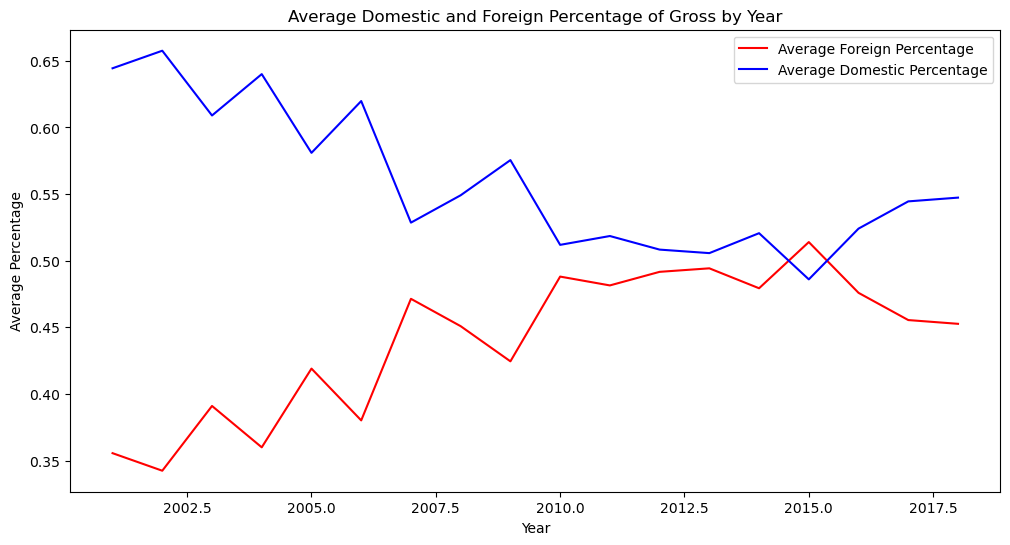

In [808]:
average_percentages = df_gross.groupby('Year')[['Foreign_Percentage', 'Domestic_Percentage']].mean()

plt.figure(figsize=(12, 6))

plt.plot(average_percentages.index, average_percentages['Foreign_Percentage'], color='red', label='Average Foreign Percentage')

plt.plot(average_percentages.index, average_percentages['Domestic_Percentage'], color='blue', label='Average Domestic Percentage')

plt.xlabel('Year')
plt.ylabel('Average Percentage')
plt.title('Average Domestic and Foreign Percentage of Gross by Year')
plt.legend()

plt.show()

The graph above clearly shows that the domestic share of the total revenue has fallen from 2000 onwards, and consequentially the inverse is true for the foreign share.

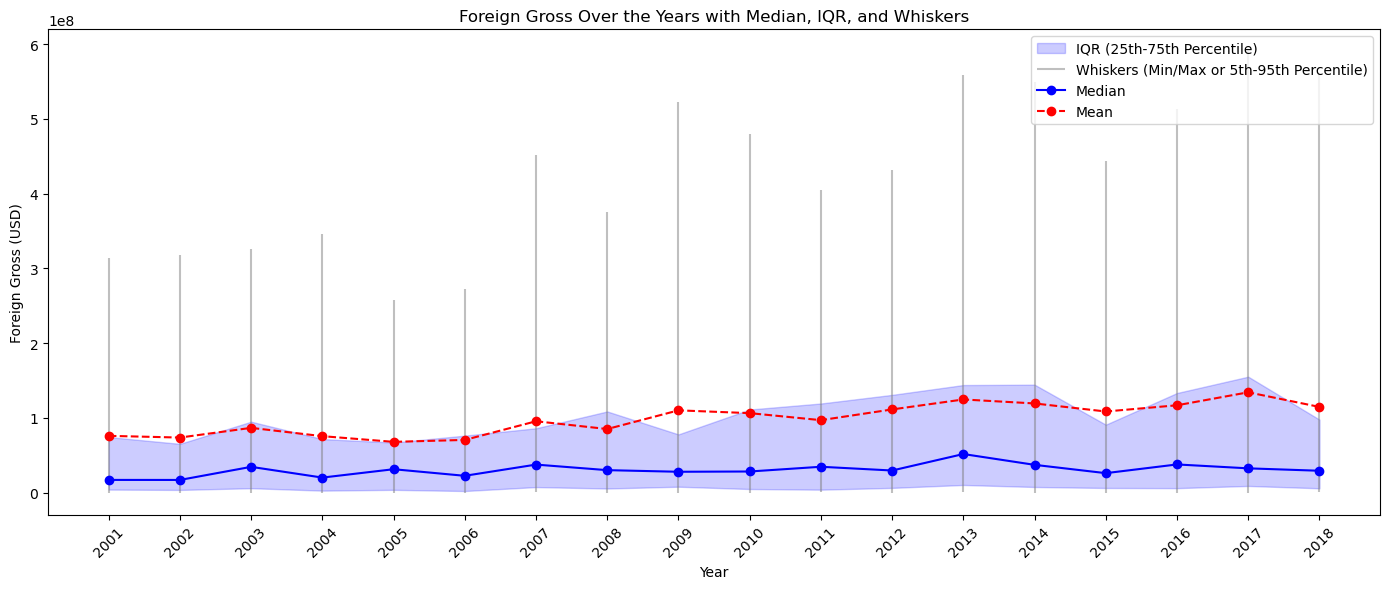

In [809]:
## SHOWING FOREIGN GROS
df_gross_filtered = df_gross[['Year', 'Foreign(USD)_Inflated']].dropna()
df_gross_filtered['Year'] = df_gross_filtered['Year'].astype(int)

# Group by 'Year' and calculate summary statistics
yearly_stats = df_gross_filtered.groupby('Year')['Foreign(USD)_Inflated'].agg(
    median='median',
    mean='mean',
    q25=lambda x: np.percentile(x, 25),  # 25th percentile
    q75=lambda x: np.percentile(x, 75),  # 75th percentile
    whisker_low=lambda x: max(np.min(x), np.percentile(x, 5)),  # Min or 5th percentile
    whisker_high=lambda x: min(np.max(x), np.percentile(x, 95))  # Max or 95th percentile
).reset_index()

# Plotting
plt.figure(figsize=(14, 6))

# Shaded area for IQR (25th to 75th percentile)
plt.fill_between(
    yearly_stats['Year'], 
    yearly_stats['q25'], 
    yearly_stats['q75'], 
    color='blue', 
    alpha=0.2, 
    label='IQR (25th-75th Percentile)'
)

# Whiskers for the range (5th to 95th percentile or min/max)
plt.vlines(
    x=yearly_stats['Year'], 
    ymin=yearly_stats['whisker_low'], 
    ymax=yearly_stats['whisker_high'], 
    color='gray', 
    alpha=0.5, 
    linewidth=1.5, 
    label='Whiskers (Min/Max or 5th-95th Percentile)'
)

plt.plot(yearly_stats['Year'], yearly_stats['median'], color='blue', linestyle='-', marker='o', label='Median')
plt.plot(yearly_stats['Year'], yearly_stats['mean'], color='red', linestyle='--', marker='o', label='Mean')
plt.xlabel('Year')
plt.ylabel('Foreign Gross (USD)')
plt.title('Foreign Gross Over the Years with Median, IQR, and Whiskers')
plt.legend()
plt.xticks(ticks=yearly_stats['Year'], rotation=45)
plt.tight_layout()
plt.show()


nOTICE THAT THE OUTLIERS VALUES HAS INCREASED IN THE LAST YEARS

## proportion of succesful movies over time

no much change in genres apart from fantasy drop

In [ ]:
genre_mapping.keys()

dict_keys(['drama', 'comedy', 'thriller', 'action', 'adventure', 'romance film', 'horror', 'fantasy', 'mystery', 'crime fiction', 'indie', 'biography', 'family film', 'sci-fi', 'period piece', 'animation', 'teen', 'film adaptation', 'family', 'musical', 'history', 'coming of age', 'sports', 'black comedy', 'war film'])

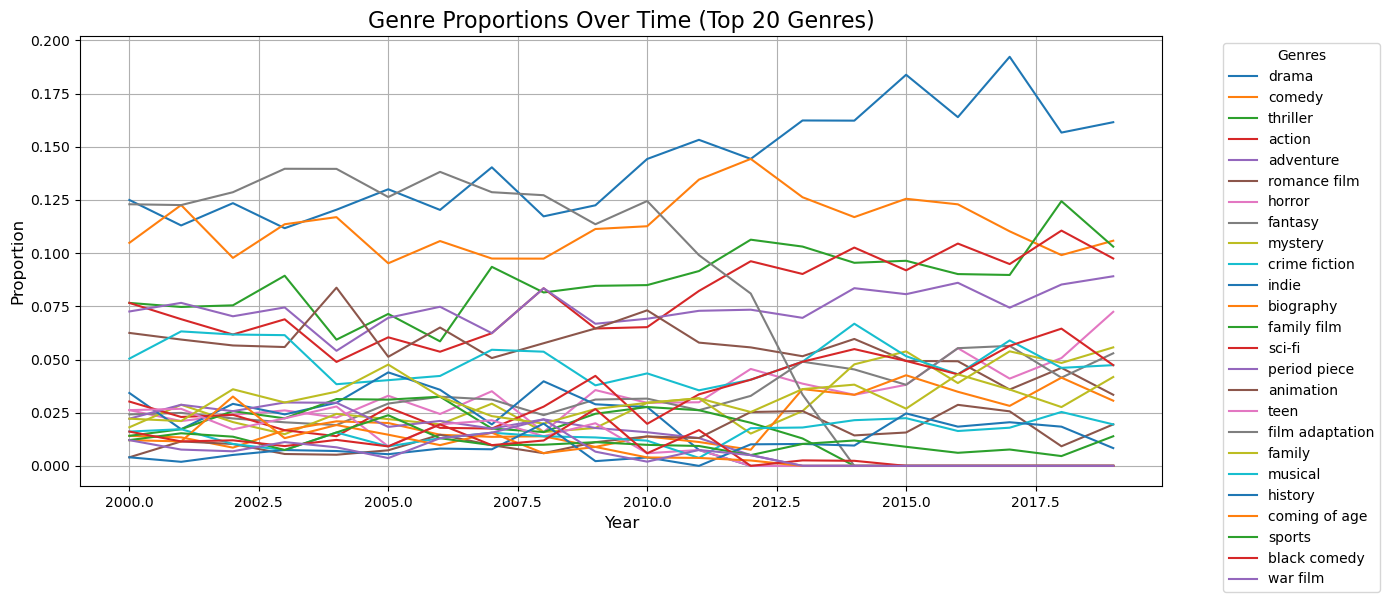

In [ ]:
import matplotlib.pyplot as plt
genre_columns_10 = list(genre_mapping.keys())
genre_yearly_counts_10 = profit_df.groupby('Year')[genre_columns_10].sum()
total_movies_per_year = profit_df.groupby('Year')[genre_columns_10].sum().sum(axis=1)
genre_proportions_10 = genre_yearly_counts_10.div(total_movies_per_year, axis=0)

# Plot the trends of genres over time (proportions)
plt.figure(figsize=(14, 6))
for genre in genre_columns_10:
    plt.plot(genre_proportions_10.index, genre_proportions_10[genre], label=genre)

plt.title('Genre Proportions Over Time (Top 20 Genres)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
stacked 

In [ ]:
profit_df.columns

Index(['Name', 'Year', 'Countries', 'Genres', 'Budget(USD)_Inflated',
       'Domestic(USD)_Inflated', 'Domestic_Percentage',
       'Foreign(USD)_Inflated', 'Foreign_Percentage',
       'Worldwide(USD)_Inflated', 'Runtime(mins)', 'Rating', 'Audience_Score',
       'Critics_Score', 'drama', 'comedy', 'thriller', 'action', 'adventure',
       'romance film', 'horror', 'fantasy', 'mystery', 'crime fiction',
       'indie', 'biography', 'family film', 'sci-fi', 'period piece',
       'animation', 'teen', 'film adaptation', 'family', 'musical', 'history',
       'coming of age', 'sports', 'black comedy', 'war film'],
      dtype='object')

<Axes: xlabel='Year'>

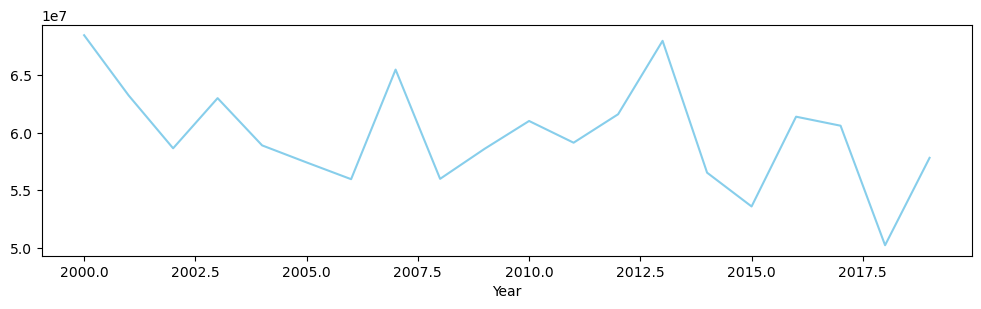

In [ ]:
import matplotlib.pyplot as plt

## spending less and 
year_counts = profit_df['Budget(USD)_Inflated'].groupby(profit_df['Year']).mean()
year_counts.plot(kind='line', color='skyblue', figsize=(12, 3))

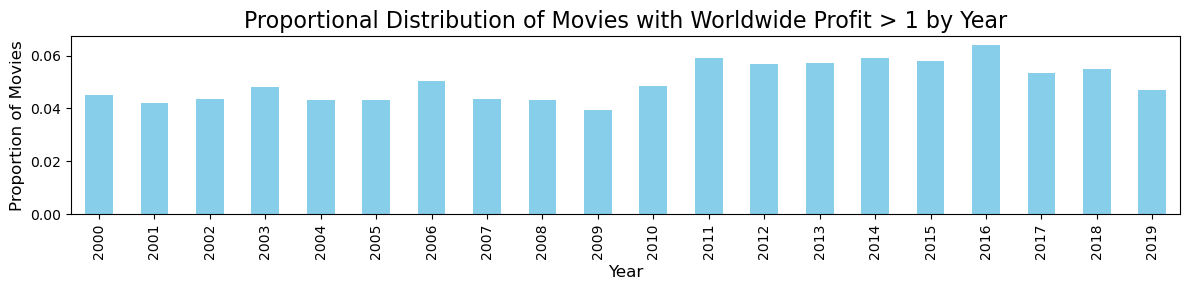

In [ ]:
import matplotlib.pyplot as plt
year_counts = profit_df[profit_df['Worldwide_profit'] > 1]['Year'].value_counts().sort_index()
year_proportions = year_counts / year_counts.sum()
plt.figure(figsize=(12, 3))
year_proportions.plot(kind='bar', color='skyblue')

plt.title('Proportional Distribution of Movies with Worldwide Profit > 1 by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of Movies', fontsize=12)
plt.tight_layout()
plt.show()


## Budget Influence

Budget vs Foreign and Domestic Income for American Movies

In [404]:
def remove_high_val(x):
    x = float(x)
    if x > 1:
        return False
    return True

Initial length of the dataset: 2713
Length after removing all the NaNs: 2713
-----------------------------------------------


c:\Users\giada\.conda\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Pearson coefficient on Budget and Domestic Percentage:
PearsonRResult(statistic=-0.3360680166306911, pvalue=1.278821732960262e-72)


c:\Users\giada\.conda\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Pearson coefficient on Budget and Foreign Percentage:
PearsonRResult(statistic=0.3360680166306909, pvalue=1.2788217329605567e-72)


,Name,Budget(USD)_Inflated,Domestic_Percentage,Foreign_Percentage
0,10 cloverfield lane,6.076746e+06,0.654010,0.345990
1,"10,000 bc",1.441563e+08,0.351333,0.648667
2,12 rounds,2.726275e+07,0.708013,0.291987
3,12 strong,3.979050e+07,0.644274,0.355726
4,12 years a slave,2.539260e+07,0.301875,0.698125


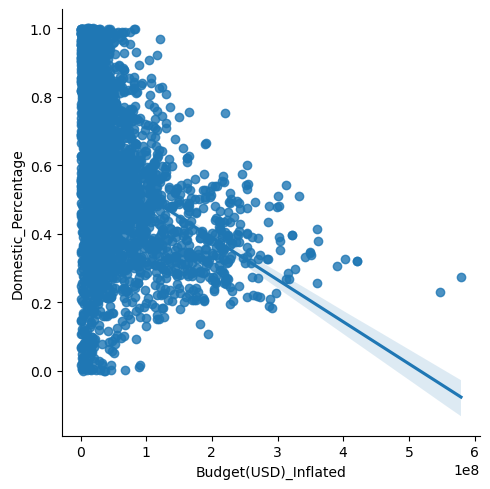

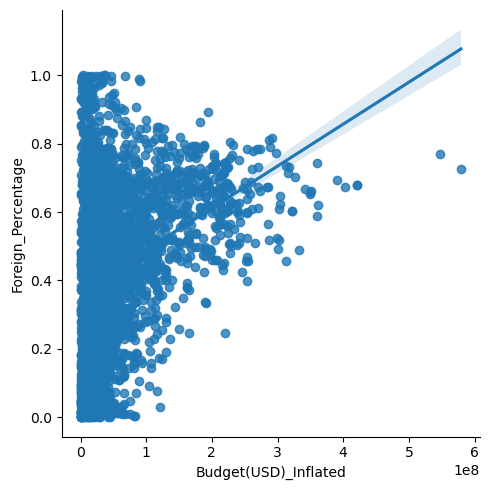

In [850]:
import seaborn as sns
from scipy import stats

df_meg_copy = profit_df.copy(deep=True)
df_meg_copy = df_meg_copy[['Name', 'Budget(USD)_Inflated', 'Domestic_Percentage', 'Foreign_Percentage']]

print(f"Initial length of the dataset: {len(df_meg_copy)}")

df_meg_copy = df_meg_copy[df_meg_copy['Budget(USD)_Inflated'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Domestic_Percentage'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Foreign_Percentage'].notna()]

print(f"Length after removing all the NaNs: {len(df_meg_copy)}")
print("-----------------------------------------------")

df_meg_copy = df_meg_copy[df_meg_copy['Foreign_Percentage'] < 1]

sns.lmplot(x='Budget(USD)_Inflated', y='Domestic_Percentage', data=df_meg_copy)
print("Pearson coefficient on Budget and Domestic Percentage:")
print(stats.pearsonr(df_meg_copy['Budget(USD)_Inflated'], df_meg_copy['Domestic_Percentage']))

sns.lmplot(x='Budget(USD)_Inflated', y='Foreign_Percentage', data=df_meg_copy)
print("Pearson coefficient on Budget and Foreign Percentage:")
print(stats.pearsonr(df_meg_copy['Budget(USD)_Inflated'], df_meg_copy['Foreign_Percentage']))

df_meg_copy.head()



In [ ]:
profit_df.columns


# TODO :OLS homework 2--
# TODO: check the variance of   

Index(['Name', 'Year', 'Countries', 'Genres', 'Budget(USD)_Inflated',
       'Domestic(USD)_Inflated', 'Domestic_Percentage',
       'Foreign(USD)_Inflated', 'Foreign_Percentage',
       'Worldwide(USD)_Inflated', 'Runtime(mins)', 'Rating', 'Audience_Score',
       'Critics_Score', 'drama', 'comedy', 'thriller', 'action', 'adventure',
       'romance film', 'horror', 'fantasy', 'mystery', 'crime fiction',
       'indie', 'biography', 'family film', 'sci-fi', 'period piece',
       'animation', 'teen', 'film adaptation', 'family', 'musical', 'history',
       'coming of age', 'sports', 'black comedy', 'war film',
       'Worldwide_profit'],
      dtype='object')

The two graphs above show a correlation where as budget increases, the income percentage that comes from foreign markets increases while it decreases for domestic markets.

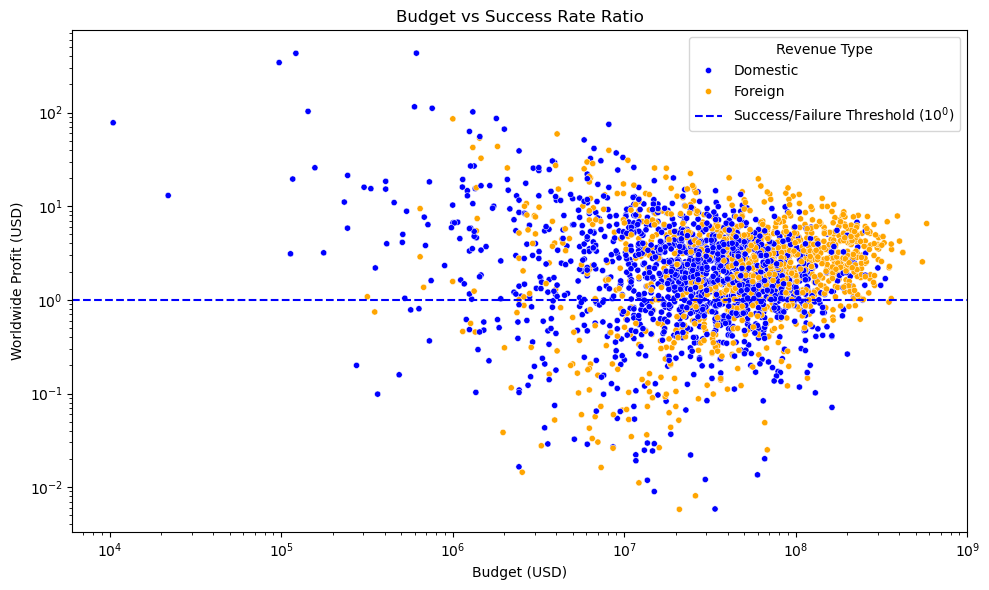

Pearson coefficient on Budget and Success Rate Ratio: -0.07472594409068196


In [863]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Copy of the final dataset
df_meg_copy = profit_df.copy(deep=True)
df_meg_copy = df_meg_copy[['Name', 'Budget(USD)_Inflated', 'Worldwide_profit', 'Domestic_Percentage', 'Foreign_Percentage']]

# Remove rows with missing data
df_meg_copy = df_meg_copy.dropna(subset=['Budget(USD)_Inflated', 'Worldwide_profit', 'Domestic_Percentage', 'Foreign_Percentage'])

# Create a new column to categorize movies based on Domestic_Percentage and Foreign_Percentage
df_meg_copy['Revenue_Type'] = df_meg_copy.apply(
    lambda row: 'Domestic' if row['Domestic_Percentage'] > row['Foreign_Percentage'] else 'Foreign', axis=1
)

# Scatter plot with lmplot (scatter + regression line)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Budget(USD)_Inflated', y='Worldwide_profit', hue='Revenue_Type', data=df_meg_copy, palette={'Domestic': 'blue', 'Foreign': 'orange'}, s=20)

# # Add a regression line (Optional, if you want to add lmplot functionality)
# sns.regplot(x='Budget(USD)_Inflated', y='Worldwide_profit', data=df_meg_copy, scatter=False, color='black')

# # Add threshold line at Worldwide_profit = 1
plt.axhline(y=1, color='blue', linestyle='--', label='Success/Failure Threshold ($10^0$)')

# Labels and Title
plt.xlabel('Budget (USD)')
plt.ylabel('Worldwide Profit (USD)')
plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs Success Rate Ratio')

# Add a legend
plt.legend(title='Revenue Type')

# Show the plot
plt.tight_layout()
plt.show()

# Calculate Pearson correlation coefficient between Budget and Success Rate Ratio
pearson_corr, _ = stats.pearsonr(df_meg_copy['Budget(USD)_Inflated'], df_meg_copy['Worldwide_profit'])
print(f"Pearson coefficient on Budget and Success Rate Ratio: {pearson_corr}")


C:\Users\giada\AppData\Local\Temp\ipykernel_24012\1425749460.py:41: UserWarning:

The figure layout has changed to tight



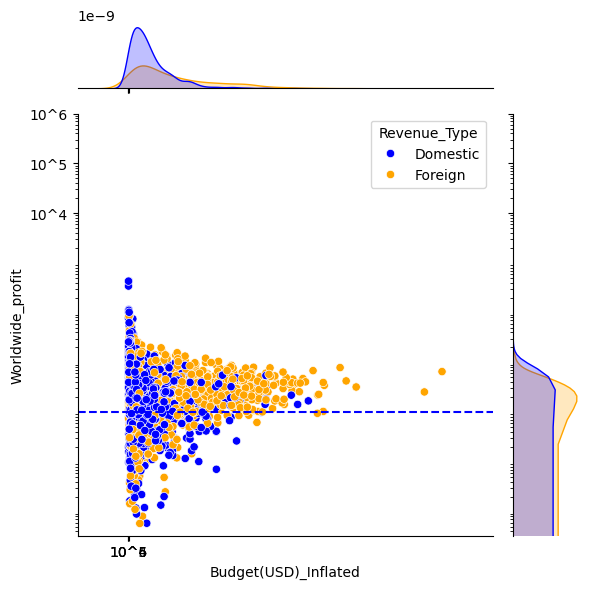

Pearson coefficient on Budget and Success Rate Ratio: -0.07472594409068196


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Copy of the final dataset
df_meg_copy = profit_df.copy(deep=True)
df_meg_copy = df_meg_copy[['Name', 'Budget(USD)_Inflated', 'Worldwide_profit', 'Domestic_Percentage', 'Foreign_Percentage']]

# Remove rows with missing data
df_meg_copy = df_meg_copy.dropna(subset=['Budget(USD)_Inflated', 'Worldwide_profit', 'Domestic_Percentage', 'Foreign_Percentage'])

# Create a new column to categorize movies based on Domestic_Percentage and Foreign_Percentage
df_meg_copy['Revenue_Type'] = df_meg_copy.apply(
    lambda row: 'Domestic' if row['Domestic_Percentage'] > row['Foreign_Percentage'] else 'Foreign', axis=1
)

# Plot using seaborn's jointplot, which will show scatter plot with histograms on x and y axes
sns.jointplot(
    x='Budget(USD)_Inflated', 
    y='Worldwide_profit', 
    data=df_meg_copy, 
    kind='scatter',  # scatter plot in the middle
    hue='Revenue_Type',  # Color by Domestic or Foreign
    palette={'Domestic': 'blue', 'Foreign': 'orange'}, 
    marginal_kws={},  # Set number of bins for histograms
)


# Add a threshold line at Worldwide_profit = 1
plt.axhline(y=1, color='blue', linestyle='--', label='Success/Failure Threshold ($10^0$)')

# Set logarithmic scale for both axes

plt.yscale('log')

# Adjust the tick labels for better visibility
plt.xticks([10**4, 10**5, 10**6], ['10^4', '10^5', '10^6'])
plt.yticks([10**4, 10**5, 10**6], ['10^4', '10^5', '10^6'])

# Show the plot
plt.tight_layout()
plt.show()

# Calculate Pearson correlation coefficient between Budget and Success Rate Ratio
pearson_corr, _ = stats.pearsonr(df_meg_copy['Budget(USD)_Inflated'], df_meg_copy['Worldwide_profit'])
print(f"Pearson coefficient on Budget and Success Rate Ratio: {pearson_corr}")


## Does runtime actually have an impact on the foreign gross?

Very weak correlation, but it seems to be that the movies with longer runtime fair better abroad in terms of percentage than domenstically, probably because the longer films are most lickely the blockbusters...
could filter out the action movies..

Initial length of the dataset: 3023
Length after removing all the NaNs: 3023
-----------------------------------------------


c:\Users\giada\.conda\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Pearson coeff on runtime and domestic gross (inflated)
PearsonRResult(statistic=0.31367815670927934, pvalue=5.210917314581307e-70)


c:\Users\giada\.conda\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Pearson coeff on runtime and foreign gross (inflated)
PearsonRResult(statistic=0.34229097012158194, pvalue=7.565053696250843e-84)


,Name,Budget(USD)_Inflated,Runtime(mins),Domestic(USD)_Inflated,Foreign(USD)_Inflated,Domestic_Percentage,Foreign_Percentage
0,10 cloverfield lane,6.076746e+06,103,8.760602e+07,4.634613e+07,0.654010,0.345990
2,"10,000 bc",1.441563e+08,109,1.301309e+08,2.402606e+08,0.351333,0.648667
4,12 rounds,2.726275e+07,108,1.667757e+07,6.877890e+06,0.708013,0.291987
5,12 strong,3.979050e+07,130,5.209113e+07,2.876133e+07,0.644274,0.355726
6,12 years a slave,2.539260e+07,134,7.195247e+07,1.663993e+08,0.301875,0.698125


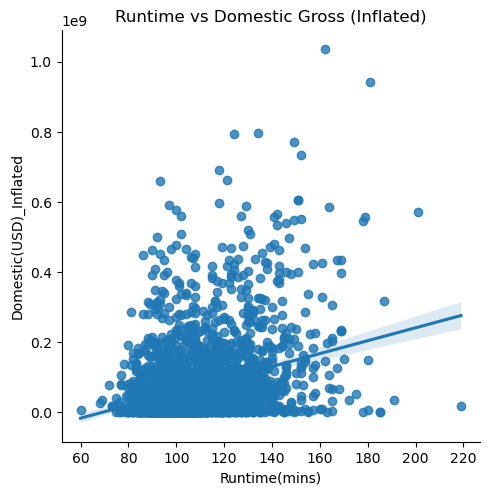

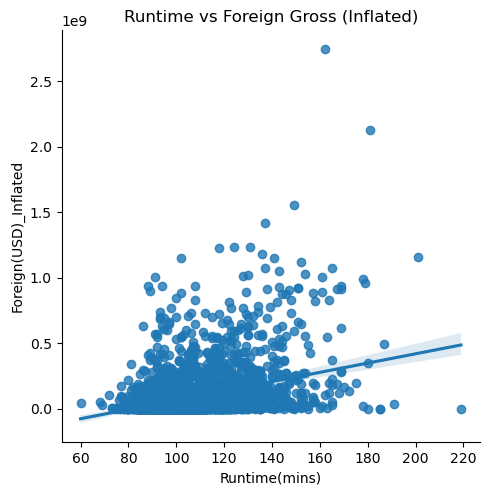

In [ ]:

# Copy and filter the dataset
df_meg_copy = final_df.copy(deep=True)
df_meg_copy = df_meg_copy[['Name', 'Budget(USD)_Inflated', 'Runtime(mins)', 'Domestic(USD)_Inflated', 
                           'Foreign(USD)_Inflated', 'Domestic_Percentage', 'Foreign_Percentage']]

print(f"Initial length of the dataset: {len(df_meg_copy)}")

df_meg_copy = df_meg_copy[df_meg_copy['Runtime(mins)'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Domestic(USD)_Inflated'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Foreign(USD)_Inflated'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Runtime(mins)'] != 0]
print(f"Length after removing all the NaNs: {len(df_meg_copy)}")
print("-----------------------------------------------")

# Plot for domestic gross vs runtime
sns.lmplot(x='Runtime(mins)', y='Domestic(USD)_Inflated', data=df_meg_copy)
plt.title('Runtime vs Domestic Gross (Inflated)')

# Pearson correlation for domestic gross
print("Pearson coeff on runtime and domestic gross (inflated)")
print(stats.pearsonr(df_meg_copy['Runtime(mins)'], df_meg_copy['Domestic(USD)_Inflated']))

# Plot for foreign gross vs runtime
sns.lmplot(x='Runtime(mins)', y='Foreign(USD)_Inflated', data=df_meg_copy)
plt.title('Runtime vs Foreign Gross (Inflated)')

# Pearson correlation for foreign gross
print("Pearson coeff on runtime and foreign gross (inflated)")
print(stats.pearsonr(df_meg_copy['Runtime(mins)'], df_meg_copy['Foreign(USD)_Inflated']))

# Display the first few rows of the filtered dataset
df_meg_copy.head()


Initial length of the dataset: 3023
Length after removing all the NaNs: 3023
-----------------------------------------------


c:\Users\giada\.conda\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Pearson coefficient on runtime and domestic USD Inflated:
PearsonRResult(statistic=-0.1592854631297163, pvalue=1.2460298980100892e-18)


c:\Users\giada\.conda\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Pearson coefficient on runtime and foreign USD Inflated:
PearsonRResult(statistic=0.15928546312971625, pvalue=1.2460298980100892e-18)


,Name,Budget(USD)_Inflated,Runtime(mins),Domestic_Percentage,Foreign_Percentage,Domestic(USD)_Inflated,Foreign(USD)_Inflated
0,10 cloverfield lane,6.076746e+06,103,0.654010,0.345990,8.760602e+07,4.634613e+07
2,"10,000 bc",1.441563e+08,109,0.351333,0.648667,1.301309e+08,2.402606e+08
4,12 rounds,2.726275e+07,108,0.708013,0.291987,1.667757e+07,6.877890e+06
5,12 strong,3.979050e+07,130,0.644274,0.355726,5.209113e+07,2.876133e+07
6,12 years a slave,2.539260e+07,134,0.301875,0.698125,7.195247e+07,1.663993e+08


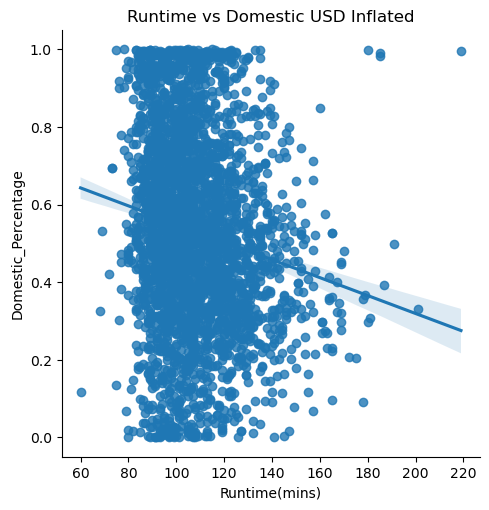

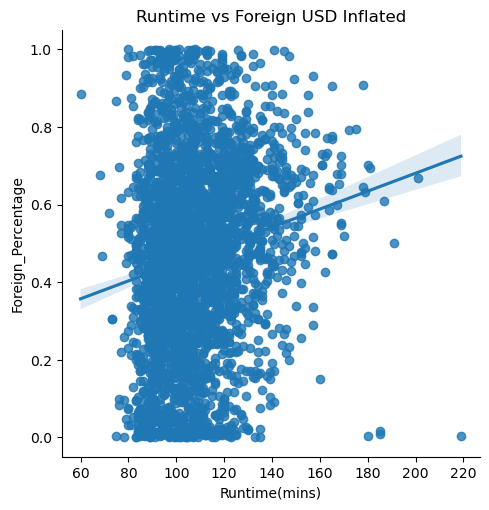

In [ ]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

df_meg_copy = final_df.copy(deep=True)
df_meg_copy = df_meg_copy[['Name', 'Budget(USD)_Inflated', 'Runtime(mins)', 'Domestic_Percentage', 'Foreign_Percentage', 'Domestic(USD)_Inflated', 'Foreign(USD)_Inflated']]

print(f"Initial length of the dataset: {len(df_meg_copy)}")

# Remove rows with missing values in the relevant columns
df_meg_copy = df_meg_copy[df_meg_copy['Budget(USD)_Inflated'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Runtime(mins)'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Domestic_Percentage'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Foreign_Percentage'].notna()]
df_meg_copy = df_meg_copy[df_meg_copy['Runtime(mins)'] != 0]

print(f"Length after removing all the NaNs: {len(df_meg_copy)}")
print("-----------------------------------------------")

# Plot for domestic percentage vs runtime
sns.lmplot(x='Runtime(mins)', y='Domestic_Percentage', data=df_meg_copy)
plt.title('Runtime vs Domestic USD Inflated')

# Pearson correlation for domestic percentage and runtime
print("Pearson coefficient on runtime and domestic USD Inflated:")
print(stats.pearsonr(df_meg_copy['Runtime(mins)'], df_meg_copy['Domestic_Percentage']))

# Plot for foreign percentage vs runtime
sns.lmplot(x='Runtime(mins)', y='Foreign_Percentage', data=df_meg_copy)
plt.title('Runtime vs Foreign USD Inflated')

# Pearson correlation for foreign percentage and runtime
print("Pearson coefficient on runtime and foreign USD Inflated:")
print(stats.pearsonr(df_meg_copy['Runtime(mins)'], df_meg_copy['Foreign_Percentage']))

# Display the first few rows of the filtered dataset
df_meg_copy.head()

## regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Prepare the dataset (with one-hot encoded genres)
X = randoom_forest_df.drop(columns=['Foreign_Percentage'])
y = randoom_forest_df['Foreign_Percentage']

# Train a Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Display the feature importances
for feature, importance in zip(X.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Year, Importance: 0.06645019241246315
Feature: Budget(USD)_Inflated, Importance: 0.2524103419931261
Feature: Runtime(mins), Importance: 0.12219658071643386
Feature: Audience_Score, Importance: 0.14307654684020404
Feature: Critics_Score, Importance: 0.1515323897988501
Feature: Cumulative_Inflation, Importance: 0.0644525551267547
Feature: drama, Importance: 0.014238925739959272
Feature: comedy, Importance: 0.03574495156403648
Feature: action, Importance: 0.01213114212279512
Feature: thriller, Importance: 0.021681070390595022
Feature: adventure, Importance: 0.00959728084154573
Feature: romance film, Importance: 0.006064847013411
Feature: horror, Importance: 0.011521505318219936
Feature: fantasy, Importance: 0.0065303901879710195
Feature: mystery, Importance: 0.0071172594924564115
Feature: crime fiction, Importance: 0.0061890708437712825
Feature: romantic comedy, Importance: 0.00490042969159459
Feature: indie, Importance: 0.007772962912293839
Feature: biography, Importance: 0.0114